In [1]:
%pylab inline
import pandas as pd
import mdtraj as md
matplotlib.rcParams.update({'font.size': 20})

Populating the interactive namespace from numpy and matplotlib


In [2]:
temps = ('300','373','423','473','523','573','623')
print len(temps)

7


In [3]:
h_u_top = md.load('/home/gerry/heat/structures/H-unbound.pdb')
h_l_top = md.load('/home/gerry/heat/structures/H-bound.pdb')

In [4]:
from itertools import combinations

def best_hummer_q(traj, native):
    """Compute the fraction of native contacts according the definition from
    Best, Hummer and Eaton [1]
    
    Parameters
    ----------
    traj : md.Trajectory
        The trajectory to do the computation for
    native : md.Trajectory
        The 'native state'. This can be an entire trajecory, or just a single frame.
        Only the first conformation is used
        
    Returns
    -------
    q : np.array, shape=(len(traj),)
        The fraction of native contacts in each frame of `traj`
        
    References
    ----------
    ..[1] Best, Hummer, and Eaton, "Native contacts determine protein folding
          mechanisms in atomistic simulations" PNAS (2013)
    """
    
    BETA_CONST = 50  # 1/nm
    LAMBDA_CONST = 1.8
    NATIVE_CUTOFF = 0.45  # nanometers
    
    # get the indices of all of the heavy atoms
    heavy = native.topology.select_atom_indices('heavy')
    # get the pairs of heavy atoms which are farther than 3
    # residues apart
    heavy_pairs = np.array(
        [(i,j) for (i,j) in combinations(heavy, 2)
            if abs(native.topology.atom(i).residue.index - \
                   native.topology.atom(j).residue.index) > 3])
    
    # compute the distances between these pairs in the native state
    heavy_pairs_distances = md.compute_distances(native[0], heavy_pairs)[0]
    # and get the pairs s.t. the distance is less than NATIVE_CUTOFF
    native_contacts = heavy_pairs[heavy_pairs_distances < NATIVE_CUTOFF]
    print("Number of native contacts", len(native_contacts))
    
    # now compute these distances for the whole trajectory
    r = md.compute_distances(traj, native_contacts)
    # and recompute them for just the native state
    r0 = md.compute_distances(native[0], native_contacts)
    
    q = np.mean(1.0 / (1 + np.exp(BETA_CONST * (r - LAMBDA_CONST * r0))), axis=1)
    return q

('Number of native contacts', 6127)
('Number of native contacts', 6127)
('Number of native contacts', 6127)
('Number of native contacts', 6127)
('Number of native contacts', 6127)
('Number of native contacts', 6127)
('Number of native contacts', 6127)
('Number of native contacts', 6127)
('Number of native contacts', 6127)
('Number of native contacts', 6127)
('Number of native contacts', 6127)
('Number of native contacts', 6127)
('Number of native contacts', 6127)
('Number of native contacts', 6127)
('Number of native contacts', 6127)
('Number of native contacts', 6127)
('Number of native contacts', 6127)
('Number of native contacts', 6127)
('Number of native contacts', 6127)
('Number of native contacts', 6127)
('Number of native contacts', 6127)


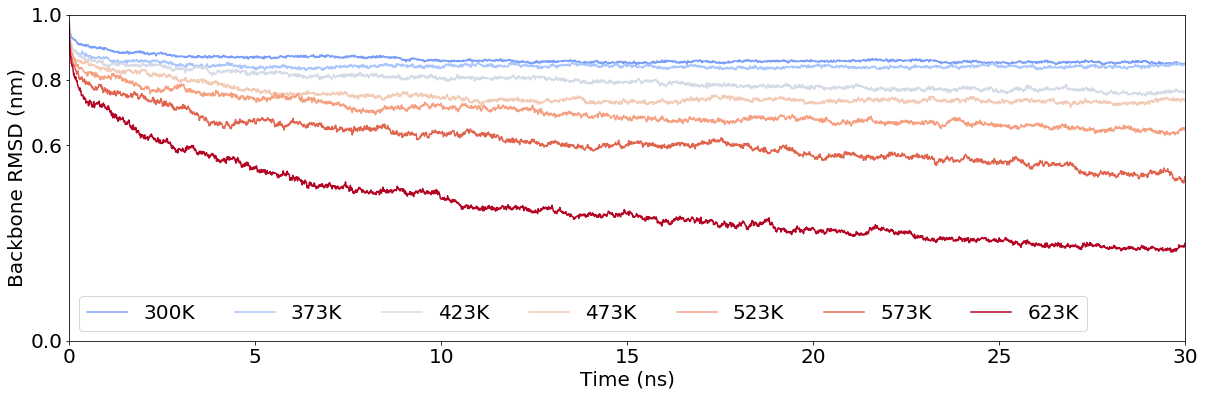

In [7]:
h_unbound_q = pd.DataFrame()

figure(figsize=(20,6))
colors = iter(cm.coolwarm(np.linspace(0.2, 1, len(temps))))
for t in temps:
    c = next(colors)
    traj = md.load_xtc('/home/gerry/heat/pro/H_unbound/H_unbound_pro_'+t+'k.xtc', top=h_u_top)
    q = best_hummer_q(traj, h_u_top)
    h_unbound_q = h_unbound_q.append(pd.Series(q), ignore_index=True)
    
    traj = md.load_xtc('/home/gerry/heat/pro/H_unbound/H_unbound_pro_'+t+'k1.xtc', top=h_u_top)
    q1 = best_hummer_q(traj, h_u_top)
    h_unbound_q = h_unbound_q.append(pd.Series(q1), ignore_index=True)
    q = (q+q1)/2

    traj = md.load_xtc('/home/gerry/heat/pro/H_unbound/H_unbound_pro_'+t+'k2.xtc', top=h_u_top)
    q2 = best_hummer_q(traj, h_u_top)
    h_unbound_q = h_unbound_q.append(pd.Series(q2), ignore_index=True)
    q = (q+q2)/2
    
    plot(q, color=c, label=t+'K')

legend(ncol=len(temps))
xlim(0,3000)
xticks(range(0,3001,500),range(0,31,5))
xlabel('Time (ns)')
yticks([0.0,0.6,0.8,1.0])
ylim(0,1)
ylabel('Backbone RMSD (nm)')

h_unbound_q.to_csv('h_unbound_q.csv', index=False)
savefig('fig_src/q.png', format='png', dpi=600, bbox_inches="tight")